## Importing the libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

## Reading in the data files

In [2]:
df_calendar = pd.read_csv('/Users/rwalters/Documents/Airbnb Data 2020/calendar.csv')
df_listings = pd.read_csv('/Users/rwalters/Documents/Airbnb Data 2020/listings.csv', dtype='str')
df_reviews = pd.read_csv('/Users/rwalters/Documents/Airbnb Data 2020/reviews.csv')

## Exploring the datasets

### Listings

In [3]:
df_listings.shape

(86358, 106)

In [4]:
# show listings data sample
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20200414180850,2020-04-16,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,2,1,1,0,0.18
1,15400,https://www.airbnb.com/rooms/15400,20200414180850,2020-04-16,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,t,f,strict_14_with_grace_period,t,t,1,1,0,0,0.71
2,17402,https://www.airbnb.com/rooms/17402,20200414180850,2020-04-15,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"This is a wonderful very popular beautiful, sp...",You'll have a wonderful stay in this superb mo...,none,"Location, location, location! You won't find b...",...,t,f,strict_14_with_grace_period,f,f,15,15,0,0,0.38
3,17506,https://www.airbnb.com/rooms/17506,20200414180850,2020-04-16,Boutique Chelsea/Fulham Double bed 5-star ensuite,Enjoy a chic stay in this elegant but fully mo...,Enjoy a boutique London townhouse bed and brea...,Enjoy a chic stay in this elegant but fully mo...,business,Fulham is 'villagey' and residential – a real ...,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,NaN
4,25023,https://www.airbnb.com/rooms/25023,20200414180850,2020-04-15,All-comforts 2-bed flat near Wimbledon tennis,"Large, all comforts, 2-bed flat; first floor; ...",10 mins walk to Southfields tube and Wimbledon...,"Large, all comforts, 2-bed flat; first floor; ...",none,This is a leafy residential area with excellen...,...,t,f,moderate,f,f,1,1,0,0,0.70


In [5]:
df_listings.dtypes

id                                              object
listing_url                                     object
scrape_id                                       object
last_scraped                                    object
name                                            object
summary                                         object
space                                           object
description                                     object
experiences_offered                             object
neighborhood_overview                           object
notes                                           object
transit                                         object
access                                          object
interaction                                     object
house_rules                                     object
thumbnail_url                                   object
medium_url                                      object
picture_url                                     object
xl_picture

In [6]:
df_listings = df_listings.dropna(subset=["review_scores_rating"])

In [7]:
def change_to_int(df):
    return df.astype('int64')

df_listings["review_scores_rating"] = change_to_int(df_listings["review_scores_rating"])

In [8]:
df_listings["review_scores_rating"].values.min()

20

In [9]:
df_listings.isnull().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                                6
summary                                          2295
space                                           15290
description                                      1153
experiences_offered                                 0
neighborhood_overview                           18435
notes                                           35498
transit                                         18714
access                                          24870
interaction                                     22207
house_rules                                     23779
thumbnail_url                                   63201
medium_url                                      63201
picture_url                                         0
xl_picture_url              

### Reviews

In [10]:
df_reviews.shape

(1513966, 6)

In [11]:
# show reviews data sample
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,13913,80770,2010-08-18,177109,Michael,My girlfriend and I hadn't known Alina before ...
1,13913,367568,2011-07-11,19835707,Mathias,Alina was a really good host. The flat is clea...
2,13913,529579,2011-09-13,1110304,Kristin,Alina is an amazing host. She made me feel rig...
3,13913,595481,2011-10-03,1216358,Camilla,"Alina's place is so nice, the room is big and ..."
4,13913,612947,2011-10-09,490840,Jorik,"Nice location in Islington area, good for shor..."


In [12]:
df_reviews.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      1
comments         716
dtype: int64

### Calendar

In [13]:
df_calendar.shape

(31522141, 7)

In [14]:
# show calendar data sample
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,140518,2020-04-17,f,$60.00,$60.00,1.0,365.0
1,13913,2020-04-16,f,$49.00,$49.00,1.0,29.0
2,13913,2020-04-17,f,$49.00,$49.00,1.0,29.0
3,13913,2020-04-18,f,$49.00,$49.00,1.0,29.0
4,13913,2020-04-19,t,$49.00,$49.00,1.0,29.0


In [15]:
df_calendar.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

## The business questions

**Question 1**

- What types of holidays are people interested in? Classification?
    - Can a recommendation be created from the reviews?

**Question 2**
- What features assist in obtaining a good review score? prefict the score, importance of the features, rank features

**Question 3**
- Is there a seasonal trend to the availability of accommodation?

In [16]:
df_calendar.isnull().sum()

listing_id           0
date                 0
available            0
price               27
adjusted_price      27
minimum_nights    1060
maximum_nights    1060
dtype: int64

In [17]:
df_calendar = df_calendar.fillna(0)

In [18]:
df_calendar.isnull().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

In [19]:
def change_to_float(df):
    df = df.str.replace(',', '')
    return df.str.replace('$', '').astype('float64')

In [20]:
def change_to_int(df):
    return df.astype('int64')

In [21]:
df_calendar['price'] = change_to_float(df_calendar['price'])
df_calendar['adjusted_price'] = change_to_float(df_calendar['adjusted_price'])

In [22]:
df_calendar['minimum_nights'] = change_to_int(df_calendar['minimum_nights'])
df_calendar['maximum_nights'] = change_to_int(df_calendar['maximum_nights'])

In [23]:
df_calendar['date'] = df_calendar['date'].astype('datetime64[ns]')

In [24]:
df_calendar.dtypes

listing_id                 int64
date              datetime64[ns]
available                 object
price                    float64
adjusted_price           float64
minimum_nights             int64
maximum_nights             int64
dtype: object

In [25]:
df_calendar.describe()

,listing_id,price,adjusted_price,minimum_nights,maximum_nights
count,3.152214e+07,3.152211e+07,3.152211e+07,3.152214e+07,3.152214e+07
mean,2.511521e+07,1.324453e+02,1.323354e+02,5.213892e+00,6.114895e+05
std,1.238298e+07,2.849468e+02,2.847640e+02,2.778766e+01,3.588058e+07
min,1.391300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.553031e+07,4.600000e+01,4.500000e+01,1.000000e+00,6.500000e+01
50%,2.573360e+07,8.400000e+01,8.400000e+01,2.000000e+00,1.125000e+03
75%,3.654173e+07,1.480000e+02,1.470000e+02,3.000000e+00,1.125000e+03
max,4.318679e+07,1.998500e+04,1.998500e+04,1.125000e+03,2.147484e+09


In [32]:
avg_price = df_calendar.groupby("date").agg({'price': np.mean}).reset_index()

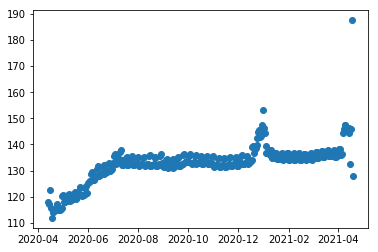

In [33]:
plt.plot_date(avg_price['date'], avg_price['price'])
plt.show()

**Question 4**
- What is the average price for the different location? what would affect this price? rank features by importance

**Question 5**
- What type of accommodation is most popular? i.e. number of rooms availble

Airbnb current challanges? 